# 2. Building, training and testing a fully-connected feedforward model and CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transform

from torch.utils.data.sampler import SubsetRandomSampler

import math
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.8.1+cu111
0.9.1+cu111


In [3]:
torch.manual_seed(42)

Setting a random seed to ensure that results are reproducible

In [4]:
torch.cuda.device_count()

1

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using GPU: {use_cuda}")

Using GPU: True


Checking if we can use GPU for a training/testing process

In [6]:
train_set = torch.load("..\\data\\processed\\train.pt")
test_set = torch.load("..\\data\\processed\\test.pt")

Loading our previously processed train and test sets

In [7]:
image, target = train_set[0]

In [8]:
image.shape

torch.Size([1, 28, 28])

In [9]:
image.max()

tensor(1.)

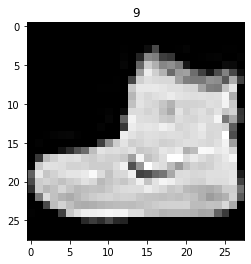

In [10]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(target)
plt.show()

Checking if everything is as it should be (shape, max value, etc.)

In [11]:
targets = train_set.targets

train_idx, valid_idx= train_test_split(
    torch.arange(len(targets)), test_size=0.2, random_state=42, shuffle=True, stratify=targets)

In [12]:
train_batch_size = 64
valid_batch_size = len(valid_idx)

In [13]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=train_batch_size, sampler=train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    train_set, batch_size=valid_batch_size, sampler=valid_sampler
)

Splitting our initial training set into two new subsets (training set & validation set) in stratified fashion. Validation set is useful for hyperparameters tuning.

## Tips & Tricks for creating and training a neural network

**Transfer Learning:**
 - method where a model developed for a task is reused as the starting point for a model on a second task
 - e.g. using models that are already trained on the ImageNet dataset, like AlexNet, VGGs, GoogLeNet, ResNets, etc. (for CV problem)
 - you can use CNN as a feature extractor where you remove last layer and freeze all others or if you have a bigger dataset you can fine-tune that pretrained model. You can only change the number of nodes in the last, output layer to fit it for your problem
 
**Number of hidden layers:**
 - None: Only capable of representing linear separable functions or decisions
 - One: Can approximate any function that contains a continuous mapping from one finite space to another
 - Two: Can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy
 - More than two: Additional layers can learn complex representations (sort of automatic feature engineering) for layer layers
 
**Number of hidden units:**
 - The number of hidden neurons should be between the size of the input layer and the size of the output layer
 - The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer
 - The number of hidden neurons should be less than twice the size of the input layer
 
**Activation functions:** 
 - Don't think too hard. Just use ReLU.
 - Try out Leaky ReLU / ELU / SELU / GELU
   if you need to squeeze that last 0.1%
 - Don't use sigmoid or tanh
 
**Data Preprocessing:**
 - Images:
     - Subtract the mean image (mean image = [32, 32, 3] array)
     - Subtract per-channel mean (mean along each channel = 3 numbers)
     - Subtract per-channel mean and divide by per-channel std (mean along each channel = 3 numbers)
 - Non-image data:
     - Zero centering (subtracting a mean)
     - Normalizing (Dividing by std)
     - PCA
     - Data Whitening
     
**Weight Initialization:**

 - Rough idea is to use small random numbers (e.g. Gaussian with zero mean, std=0.01) - but it's not good for deeper networks (all activations tend to zero for deeper network layers)
 - Best use case for ReLU activation function is a "Kaiming He weight initialization"
 - Residual networks can't use a plain version of the Kaiming He w.i., we must modified it a little bit
 
**Learning rate:**
 - probably the most important hyperparameter that you need to set for most deep learning models
 
 - ![Learning rates](..\reports\figures\learning_rates.png)
 - Learning rate decay - start with large learning rate and decay over time. There are different options:
     - Step decay (e.g. multiply LR by 0.1 after epochs 30, 60 and 90.
     - Cosine
     - Linear
     - Inverse Sqrt
     - Constant (recommended option; you can try other options if you're really trying to push for the state of the art on some problem)
 - ![Loss plateaus](..\reports\figures\loss_plateaus.png)    
 - ![Decaying too early](..\reports\figures\too_early_decay.png)
 - Last tip for a learning rate is to use the so-called "Learning rate finder" function. During one epoch you can try different learning rates (in ascending order, from smaller values to larger) and choose the best one. Next figure is showing this process
 - ![Learning rate finder](..\reports\figures\learning_rate_finder.png)


**Regularization:**
 - A common pattern is next:
     - While training: add some kind of randomness
     - While testing: average out randomness (sometimes approximate)
 - L1 regularization
 - L2 regularization (a.k.a. weight decay)
 - Elastic net (L1 + L2)
 - Batch Normalization
 
 - For ResNet and later, often L2 and Batch Normalization are the only regularizers!
 
 - Dropout (usually applied in fully-connected layers; slightly less important in modern architectures because they are using global average pooling instead of fully-connected layers)
 - Data Augmentation:
     - horizontal/vertical flip
     - random crops and scales
     - color jitter
     - gaussian noise
     - rotation
     - translation
     - shearing
     - stretching
     - lens distortions
     - conditional GANs
     - interpolation (constant, edge, reflect, symmetric, wrap, ...)
 - Stochastic Depth
 - DropConnect
 - Fractional Max Pooling
 - Cutout
 - Mixup
 
 - Conclusion about regularization:
  - consider dropout for large fully-connected layers
  - <span style="color:Maroon">batch normalization, weight decay and data augmentation are almost always a good idea</span>
  - try cutout and mixup especially for small classification datasets

 
**Optimizers:**
 - Start with some advanced optimizers like Adam, RMSProp or SGD with Momentum
 
**Loss functions:**
 - Classification problem:
     - Binary:
         - <span style="color:Maroon">Binary Cross-Entropy Loss (most used)</span>
         - Hinge Loss
         - Squared Hinge Loss
     - Multi-Class:
         - <span style="color:Maroon">Multi-Class Cross-Entropy Loss (most used)</span>
         - Sparse Multiclass Cross-Entropy Loss
         - Kullback Leibler Divergence Loss
         
     - Multi-Label:
         - Binary Cross-Entropy Loss (specifying the number of target labels there is in the problem as the number of nodes in the output layer; For example, a task that has three output labels (classes) will require a neural network output layer with three nodes in the output layer.)  
         
 - Regression problem:
     - <span style="color:Maroon">Mean Squared Error Loss (most used)</span>
     - Mean Squared Logarithmic Error Loss
     - Mean Absolute Error Loss

**Early stopping:**
 - This can also be a regularization technique but I'll make it as a separate trick for the training process
 - Stop training the model when accuracy on the validation set decreases (always a good idea to do this)
 - ![Early stopping](..\reports\figures\early_stopping.png)
 
**Choosing hyperparameters:**
 - Choose several values for each hyperparameter (often space choices log-linearly)
 - Grid Search (e.g. Weight decay: [1x10^-4, 1x10^-3, 1x10^-2, 1x10^-1], learning rate: [1x10^-4, 1x10^-3, 1x10^-2, 1x10^-1]; evaluate all possible choices on this hyperparameter grid)
 - Random Search
 - Bayesian Optimization
 
 
**Learning curves:**
 - ![Desired Learning Curves](..\reports\figures\desired_learning_curves.png)
 - ![Overfitting](..\reports\figures\overfitting.png)
 - ![Underfitting](..\reports\figures\underfitting.png)
 - One note for the last one, where the model is underfitting. For many tasks we know in advance what accuracy is acceptable. If our train & valid accuracy are relatively low in comparison to this acceptable/desired accuracy, our model is underfitting.
 - ![Bad initialization](..\reports\figures\bad_initialization.png)
 
**Another option for choosing hyperparameters**:
 - Step 1: Check initial loss (turn off weight decay, sanity check loss at initialization, e.g. log(C) or -log(1/C) for softmax with C classes)
 - Step 2: Overfit a small sample (try to train to 100% training accuracy on small sample of training data (~5-10 minibatches); fiddle with architecture, learning rate, weight initialization. Turn off regularization. Loss not going down? LR too low, bad initialization. Loss explodes to Inf or NaN? LR too high, bad initialization
 - Step 3: Find LR that makes loss go down (use architecture from the previous step, use all training data, turn on small weight decay, find a learning rate that makes the loss drop significantly within ~100 iterations; good LRs to try: 1e-1, 1e-2, 1e-3, 1e-4)
 - Step 4: Coarse grid, train for ~1-5 epochs (choose a few values of the learning rate and weight decay around what worked from Step 3, train a few models fro ~1-5 epochs; good weight decay to try: 1e-4, 1e-5, 0)
 - Step 5: Refine grid, traing longer (pick best models from Step 4, train them for longer (~10-20 epochs) without learning rate decay
 - Step 6: Look at learning curves
 - Step 7: GOTO step 5
 
**Last tips:**
 - Set up some kind of a cross-validation "command center" with e.g. TensorBoard
 - Track ratio of weight update and weight magnitude (weight_update / weight_magnitude). Want this to be somewhere around .001 or so

In [14]:
class FCFFM(nn.Module):
    def __init__(self, n_features, n_outputs):
        super().__init__()
        
        self.n_features = n_features
        self.n_outputs = n_outputs
        
        self.units_by_layer = [self.n_features, self.n_outputs]
        
        for i in range(1, 4):
            self.n_features = math.floor(self.n_features / 2)
            self.units_by_layer.insert(i, self.n_features)
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.units_by_layer[0], self.units_by_layer[1]),
            nn.LeakyReLU(),
            nn.Linear(self.units_by_layer[1], self.units_by_layer[2]),
            nn.LeakyReLU(),
            nn.Linear(self.units_by_layer[2], self.units_by_layer[3]),
            nn.LeakyReLU(),
            nn.Linear(self.units_by_layer[3], self.units_by_layer[4])
            )
        
    def forward(self, t):
        
        return self.layers(t)

We've created a 4-layer fully-connected feedforward model/neural network

In [15]:
def create_sequential_model(n_features, n_layers, n_outputs):
    
    layers = []
    
    for i in range(n_layers):
        if i == 0:
            n_nodes = math.floor(n_features / 2)
            layers.extend((nn.Flatten(), nn.Linear(n_features, n_nodes), nn.LeakyReLU()))
        elif i == n_layers - 1:
            layers.append(nn.Linear(n_nodes, n_outputs))
        else:
            n_features = math.floor(n_nodes / 2)
            layers.extend((nn.Linear(n_nodes, n_features), nn.LeakyReLU()))
            n_nodes = n_features
    
    return nn.Sequential(*layers).to(device)

Another way (only with the nn.sequential class) to create the same model but without the need to build an explicit class

In [55]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=(3, 3)),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=(1, 1)),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, kernel_size=1, stride=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=(1, 1)),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=(1, 1)),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=(1, 1)),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), #Global Average Pooling
    nn.Flatten(),
    nn.Linear(128, 10)
).to(device)

Simple CNN

In [56]:
image, _ = train_set[0]

n_features = image.numel()

n_outputs = len(train_set.classes)

model = FCFFM(n_features, n_outputs).to(device)

#n_layers = 4
#seq_model = create_sequential_model(n_features, n_layers, n_outputs)

optimizer = optim.Adam(cnn.parameters())

n_epochs = 20

train_set_len = len(train_set)

There are 3 different models that you can try (model, seq_model & cnn)

In [51]:
def find_optimal_learning_rate(model, tr_load_len, optimizer, init_value=1e-8, final_value=10., beta=.98):
    potential_lrs = np.geomspace(init_value, final_value, tr_load_len)    
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    
    for batch in train_loader:
        lr = potential_lrs[batch_num]
        optimizer.param_groups[0]["lr"] = lr
        batch_num += 1
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        
        preds = model(images)
        loss = F.cross_entropy(preds, targets)
        
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        if (smoothed_loss > 4 * best_loss) and batch_num > 1:
            return log_lrs, losses
        
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return log_lrs, losses

Previously mentioned learning rate finder.

In [52]:
tr_load_len = len(train_loader)
log_lrs, losses = find_optimal_learning_rate(cnn, tr_load_len, optimizer)

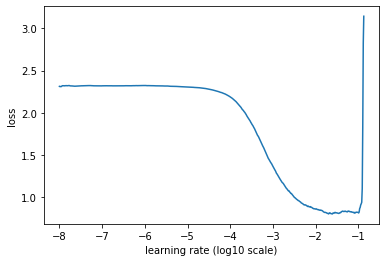

In [53]:
plt.plot(log_lrs, losses)
plt.xlabel("learning rate (log10 scale)")
plt.ylabel("loss")
plt.show()

Looking to this plot above, the best value for a learning rate would be something between 5e-4 and 3e-3 (e.g. 5e-4, 7e-4, 9e-4, 1e-3, 3e-3)

In [64]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [26]:
#optimizer.param_groups[0]["lr"] = 3e-3

Before we start with the training process we must reinitialize the CNNs weights. They are disrupted with high value of the learning rate in our one-epoch training process within the "find_optimal_learning_rate" function

In [58]:
def train_and_validate(model, train_loader, valid_loader, optimizer, train_set_len, n_epochs):
    
    mean_train_losses_list = []
    train_accs_list = []
    valid_accs_list = []
    
    for e in range(1, n_epochs + 1):
    
        total_train_loss = 0

        for batch in train_loader:
            images, targets = batch

            images = images.to(device)
            targets = targets.to(device)

            preds = model(images)
            loss = F.cross_entropy(preds, targets, reduction="sum")
            
            train_acc = (preds.argmax(dim=1) == targets).sum().item() / len(targets)
            
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        mean_train_loss = total_train_loss / train_set_len
        
        mean_train_losses_list.append(mean_train_loss)
        train_accs_list.append(train_acc)
        
        model.eval()
        with torch.no_grad():
            valid_images, valid_targets = next(iter(valid_loader))

            valid_images = valid_images.to(device)
            valid_targets = valid_targets.to(device)

            valid_unnorm_preds = model(valid_images)
            
            valid_acc = (valid_unnorm_preds.argmax(dim=1) == valid_targets).sum().item() / len(valid_targets)
        
        valid_accs_list.append(valid_acc)
        
        model.train()

        print(f"epoch: {e}, mean train loss: {mean_train_loss}, train acc: {train_acc}, valid acc: {valid_acc}")
    
    return mean_train_losses_list, train_accs_list, valid_accs_list

In [59]:
train_loss, train_acc, valid_acc = train_and_validate(cnn, train_loader, valid_loader, optimizer, train_set_len, n_epochs)

epoch: 1, mean train loss: 0.39637642410596213, train acc: 0.859375, valid acc: 0.8603333333333333
epoch: 2, mean train loss: 0.24622177341779072, train acc: 0.875, valid acc: 0.8415
epoch: 3, mean train loss: 0.21652299579779308, train acc: 0.90625, valid acc: 0.9044166666666666
epoch: 4, mean train loss: 0.19639174331029255, train acc: 0.875, valid acc: 0.8913333333333333
epoch: 5, mean train loss: 0.18256976453463236, train acc: 0.90625, valid acc: 0.8701666666666666
epoch: 6, mean train loss: 0.1702299985488256, train acc: 0.953125, valid acc: 0.8964166666666666
epoch: 7, mean train loss: 0.1623395593682925, train acc: 0.859375, valid acc: 0.8925
epoch: 8, mean train loss: 0.1521442067305247, train acc: 0.859375, valid acc: 0.9074166666666666
epoch: 9, mean train loss: 0.1449883909225464, train acc: 0.96875, valid acc: 0.914
epoch: 10, mean train loss: 0.13707598915100097, train acc: 0.9375, valid acc: 0.9163333333333333
epoch: 11, mean train loss: 0.13009456833998362, train acc: 0

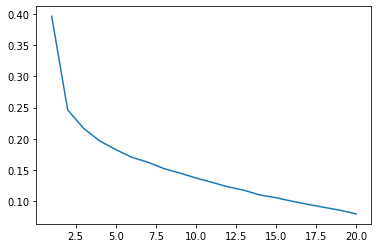

In [60]:
plt.plot(range(1, n_epochs + 1), train_loss)
plt.show()

In [61]:
df = pd.DataFrame({"train_acc": train_acc})

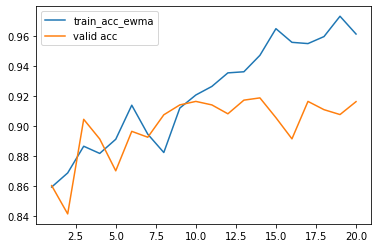

In [62]:
#For a larger number of epochs you can better see a smoothing effect of the exponentially weighted moving average
plt.plot(range(1, n_epochs + 1), df["train_acc"].ewm(span=5).mean(), label="train_acc_ewma")
plt.plot(range(1, n_epochs + 1), valid_acc, label="valid acc")
plt.legend()
plt.show()

<ipython-input-44-0cd7d3af20a0>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  axes.append(fig.add_subplot(math.sqrt(n_neurons), math.sqrt(n_neurons), i+1))


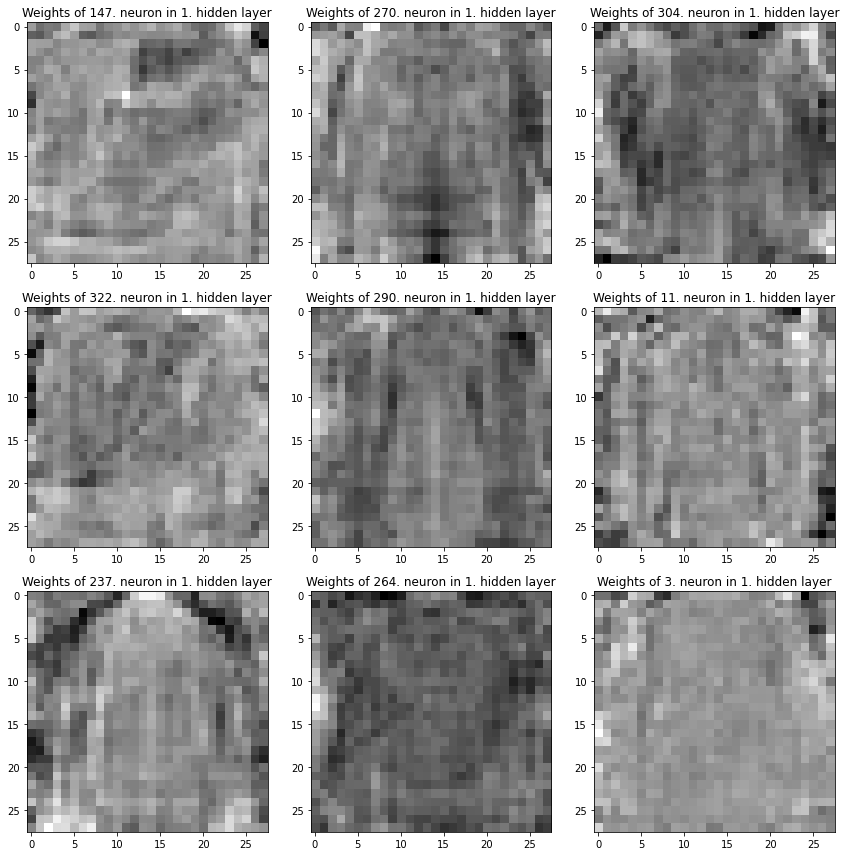

In [44]:
n_neurons = 9
random_neurons = np.random.randint(1, math.floor(n_features / 2), size=n_neurons)
axes = []
fig = plt.figure(figsize=(12, 12))

for i, n in enumerate(random_neurons):
    weights = model.layers[1].weight[n, :].view(28, 28).cpu().detach().numpy()
    axes.append(fig.add_subplot(math.sqrt(n_neurons), math.sqrt(n_neurons), i+1))
    subplot_title=(f"Weights of {n}. neuron in 1. hidden layer")
    axes[-1].set_title(subplot_title)  
    plt.imshow(weights, cmap="gray")
    
fig.tight_layout()    
plt.show()

Visualizing the weights of 9 random neurons in the first layer of our FCFFM.

<ipython-input-68-880fabf825d0>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  axes.append(fig.add_subplot(math.sqrt(n_filters), math.sqrt(n_filters), i+1))


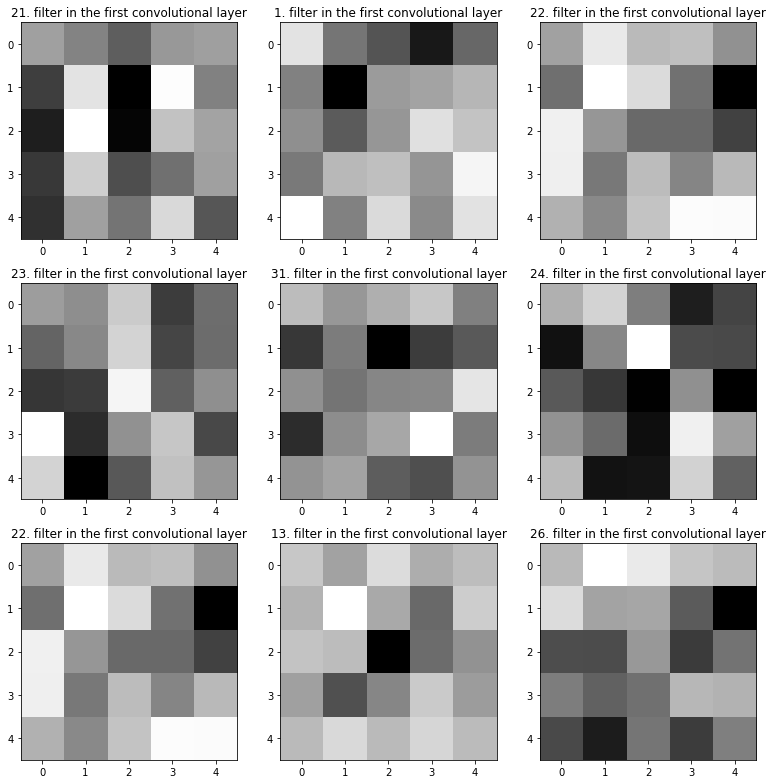

In [68]:
n_filters = 9
random_filters = np.random.randint(1, cnn[0].weight.shape[0], size=n_filters)
axes = []
fig = plt.figure(figsize=(11, 11))

for i, n in enumerate(random_filters):
    filter = cnn[0].weight[n].squeeze().cpu().detach().numpy()
    axes.append(fig.add_subplot(math.sqrt(n_filters), math.sqrt(n_filters), i+1))
    subplot_title=(f"{n}. filter in the first convolutional layer")
    axes[-1].set_title(subplot_title)  
    plt.imshow(filter, cmap="gray")
    
fig.tight_layout()    
plt.show()

Visualizing the first layer filters of our CNN

In [36]:
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=len(test_set)
)

Creating the test set data loader

In [37]:
def test(model, test_loader):
    
    model.eval()
    with torch.no_grad():
        test_images, test_targets = next(iter(test_loader))

        test_images = test_images.to(device)
        test_targets = test_targets.to(device)

        test_unnorm_preds = model(test_images)

        test_acc = (test_unnorm_preds.argmax(dim=1) == test_targets).sum() / len(test_targets)
        
        print(f"test acc: {test_acc}")

In [38]:
test(cnn, test_loader)

test acc: 0.909500002861023


When you finish with a process of fine-tuning, i.e. when you have a descent validation score/accuracy, it's time to calculate the test set accuracy which is the most important accuracy. You should run this command only once and record your accuracy. That's the end, you can't fine-tune your model anymore.

In [ ]:
torch.save(model.state_dict(), "fashion_mnist_fcffm.pt") #or "fashion_mnist_cnn.pt"
#model.load_state_dict(torch.load("fashion_mnist_fcffm.pt"))

Commands for saving and restoring model weights